# pySEAFOM Self-Noise Test — Synthetic Data

**Repository**: SEAFOM-Fiber-Optic-Monitoring-Group/pySEAFOM

This notebook demonstrates and validates the self-noise calculation functionality in the pySEAFOM library using synthetic DAS data.

## Overview

This test notebook:
- Generates synthetic DAS time series with a known amplitude spectral density (ASD)
- Validates the `calculate_self_noise()` function against the known ASD
- Demonstrates the `plot_combined_self_noise_db()` visualization function
- Provides quantitative error metrics to verify accuracy

The synthetic data mimics real DAS measurements with configurable sampling rate, duration, and number of channels.

## 1. Setup and Imports

Import required libraries and add the `source` directory to the Python path to access the `self_noise` module.

In [10]:
# Imports and setup
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
repo_root = Path.cwd()
src_dir = repo_root / 'source' / 'pySEAFOM'
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))
#import self_noise  # if using relative import
from pySEAFOM import self_noise # if using installed package import

## 2.Configure the test parameters:

### User-Configurable Parameters
- **`fs`**: Sampling rate in Hz (10 kHz is typical for DAS systems)
- **`duration`**: Duration in seconds (120 s provides excellent frequency resolution)
- **`n_channels`**: Total number of channels to synthesize (100 channels)
- **`test_sections_channels`**: List of [start, end] channel ranges for each test section
  - Example: `[[0, 40], [60, 99]]` defines two sections:
    - Section 1: channels 0–40 (41 channels)
    - Section 2: channels 60–99 (40 channels)
  - Allows testing different cable sections or spatial locations
- **`test_sections`**: Names/labels for each section (must match length of `test_sections_channels`)
  - Example: `['Section 1', 'Section 2']`


In [ ]:
## User-defined parameters
fs = 10000                
gauge_length = 10.0
test_sections_channels=[[0,40],[60,99]]
test_sections =['Section 1', 'Section 2']
data_unit = 'pε'


## 3. Create Synthetic Data [Optional - Skip if Using Real Data]

**Note**: This section generates synthetic test data. If you have actual DAS measurements, you can skip this section and load your real data instead (e.g., `data = np.load('your_data.npy')`).

### Computed Parameters
- **Known ASD**: User-defined spectral shape across 0–5000 Hz
- **Frequency resolution**: Determines how well we can resolve low-frequency features

The `test_sections_channels` parameter allows you to simulate and analyze different fiber sections independently, which is useful for comparing self-noise across different parts of a cable installation.


Generate synthetic time series whose FFT magnitudes match the target ASD.

**Method**:
1. Use `np.fft.rfftfreq()` to create frequency bins matching the library's output
2. Set FFT magnitudes to match the known ASD (accounting for window normalization)
3. Randomize phases to create realistic noise-like signals
4. Inverse FFT to obtain time-domain traces

This ensures the library's `calculate_self_noise()` should recover the known ASD when using `window_function='none'`.

Sampling rate: 10000 Hz
Duration: 120 s
Total samples: 1200000
Frequency resolution: 0.0083 Hz
FFT bins: 600001, freqs[0]=0.0, freqs[-1]=5000.0


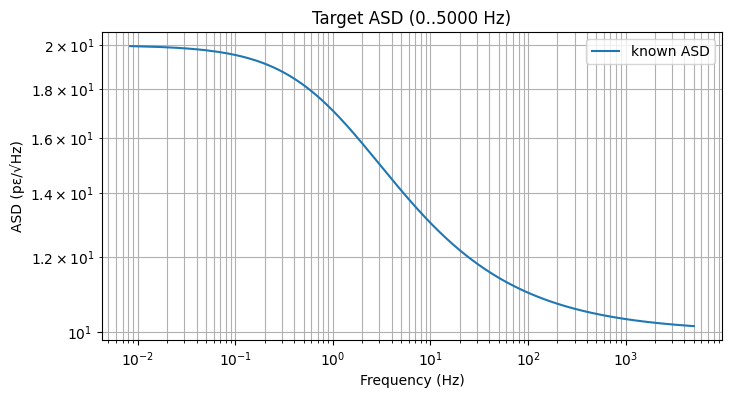

In [ ]:
## Design and plot known ASD
duration = 120       
n_channels = 100   
N = fs * duration       
freqs = np.fft.rfftfreq(N, 1.0/fs)  # 0 .. 5000 Hz
M = freqs.size
freq_resolution = fs / N
print(f'Sampling rate: {fs} Hz')
print(f'Duration: {duration} s')
print(f'Total samples: {N}')
print(f'Frequency resolution: {freq_resolution:.4f} Hz')
print(f'FFT bins: {M}, freqs[0]={freqs[0]}, freqs[-1]={freqs[-1]:.1f}')

f = freqs.copy()
known_asd = 10.0 * (1.0 + 1.0/np.sqrt(f + 1.0))  # ~20 pε/√Hz at 1 Hz, ~10 pε/√Hz at high freq

scale = np.sqrt(N * fs / 2.0)
target_mag = known_asd * scale
rng = np.random.default_rng(12345)
data = np.zeros((n_channels, N), dtype=float)
for ch in range(n_channels):
    phases = np.exp(1j * 2.0 * np.pi * rng.random(M))
    Xr = target_mag * phases
    x = np.fft.irfft(Xr, n=N)
    data[ch, :] = x
t = np.arange(N) / fs

# Quick plot of the target ASD
plt.figure(figsize=(8,4))
plt.loglog(freqs[1:], known_asd[1:], label='known ASD')
plt.xlabel('Frequency (Hz)')
plt.ylabel(f'ASD ({data_unit}/√Hz)')
plt.title('Target ASD (0..5000 Hz)')
plt.grid(True, which='both')
plt.legend()
plt.show()

## 4. Validate `calculate_self_noise()` Function

Call the main library function and compare results against the known ASD.

### Section Extraction
The code extracts specific channel ranges from the full synthetic dataset based on `test_sections_channels`:
```python
sections = [data[test_sections_channels[i][0]:test_sections_channels[i][1]+1, :] for i in range(len(test_sections))]
```
This creates a list of 2D arrays, one per section, where each section contains only the channels specified in `test_sections_channels`.

### Validation Metrics
- **Visual comparison**: Overlay known vs. estimated ASD (showing results from the first section)
- **Median/mean relative error** across all frequency bins
- **Per-bin error table** for the first 10 frequencies

### Expected Result
The estimated ASD should closely match the known ASD, with errors primarily due to:
- Random phase variations across channels
- Finite number of channels in the RMS average
- Numerical precision limits

Note: The validation plot shows only the first section's results, but `calculate_self_noise()` processes all sections defined in `test_sections_channels`.

Processing section 1/2
Processing section 2/2


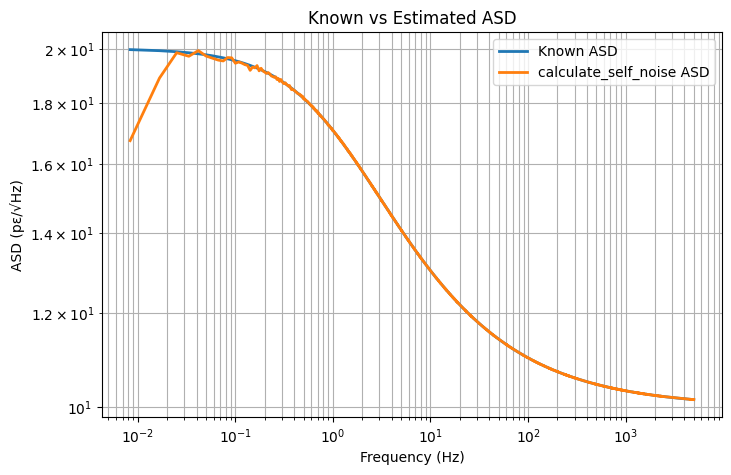

Median relative error (excluding DC): 3.423804311315838e-07
Mean relative error (excluding DC): 1.7757873642038005e-06
     0.0 Hz: known=1.996e+01, estimated=1.674e+01, rel_err=16.15%
     0.0 Hz: known=1.992e+01, estimated=1.889e+01, rel_err=5.16%
     0.0 Hz: known=1.988e+01, estimated=1.984e+01, rel_err=0.19%
     0.0 Hz: known=1.984e+01, estimated=1.970e+01, rel_err=0.67%
     0.0 Hz: known=1.980e+01, estimated=1.992e+01, rel_err=0.62%
     0.1 Hz: known=1.976e+01, estimated=1.971e+01, rel_err=0.23%
     0.1 Hz: known=1.972e+01, estimated=1.963e+01, rel_err=0.46%
     0.1 Hz: known=1.968e+01, estimated=1.956e+01, rel_err=0.63%
     0.1 Hz: known=1.964e+01, estimated=1.953e+01, rel_err=0.60%
     0.1 Hz: known=1.961e+01, estimated=1.965e+01, rel_err=0.24%


In [ ]:
sections = [data[test_sections_channels[i][0]:test_sections_channels[i][1]+1, :] for i in range(len(test_sections))]
frequency_spectra = self_noise.calculate_self_noise(sections, interrogation_rate=fs, window_function='none', data_type=data_unit)
res_freqs, res_asd = frequency_spectra[0]
# Align arrays to same length
min_len = min(len(res_freqs), len(known_asd))
res_freqs_plot = res_freqs[:min_len]
known_plot = known_asd[:min_len]
res_asd_plot = res_asd[:min_len]

# Plot known vs estimated
plt.figure(figsize=(8,5))
plt.loglog(res_freqs_plot[1:], known_plot[1:], label='Known ASD', linewidth=2)
plt.loglog(res_freqs_plot[1:], res_asd_plot[1:], label='calculate_self_noise ASD', linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel(f'ASD ({data_unit}/√Hz)')
plt.title('Known vs Estimated ASD')
plt.grid(True, which='both')
plt.legend()
plt.show()

# Numeric comparison: relative error (excluding DC bin)
rel_err = np.abs(res_asd_plot[1:] - known_plot[1:]) / known_plot[1:]
print('Median relative error (excluding DC):', np.median(rel_err))
print('Mean relative error (excluding DC):', np.mean(rel_err))
# Show a small frequency subset comparison table (print first 10 non-DC bins)
for i in range(1, min(11, min_len)):
    print(f'{res_freqs_plot[i]:8.1f} Hz: known={known_plot[i]:.3e}, estimated={res_asd_plot[i]:.3e}, rel_err={rel_err[i-1]:.2%}')


## 5. Demonstrate `plot_combined_self_noise_db()` Visualization

Test the library's plotting function with metadata overlay and multi-section comparison.

### Multi-Section Processing
The same section extraction is performed:
```python
sections = [data[test_sections_channels[i][0]:test_sections_channels[i][1]+1, :] for i in range(len(test_sections))]
```
Each section is processed independently and plotted on the same graph for comparison.

### Plot Features Demonstrated
- **Multi-section overlay**: All sections defined in `test_sections` are plotted with different colors
  - Allows visual comparison between different cable sections or spatial locations
- **dB scale conversion**: Relative to 1 pε/√Hz for industry-standard presentation
- **Log-space smoothing**: Raw data (faint) + smoothed curves (bold) for cleaner visualization
- **Frequency band highlighting**: Seismic (1–100 Hz) and Acoustic (100+ Hz) bands
- **Metadata box**: Shows measurement parameters (sampling freq, gauge length, channels/section, duration)
- **SureVISION branding**: Publication-ready output

### Customization
To test different sections:
1. Modify `test_sections_channels` to define new channel ranges
2. Update `test_sections` with corresponding labels
3. Re-run cells 4 and 5 to see results for the new sections

This function is designed for presenting final self-noise test results in reports and comparing performance across different fiber sections.

Processing section 1/2
Processing section 2/2


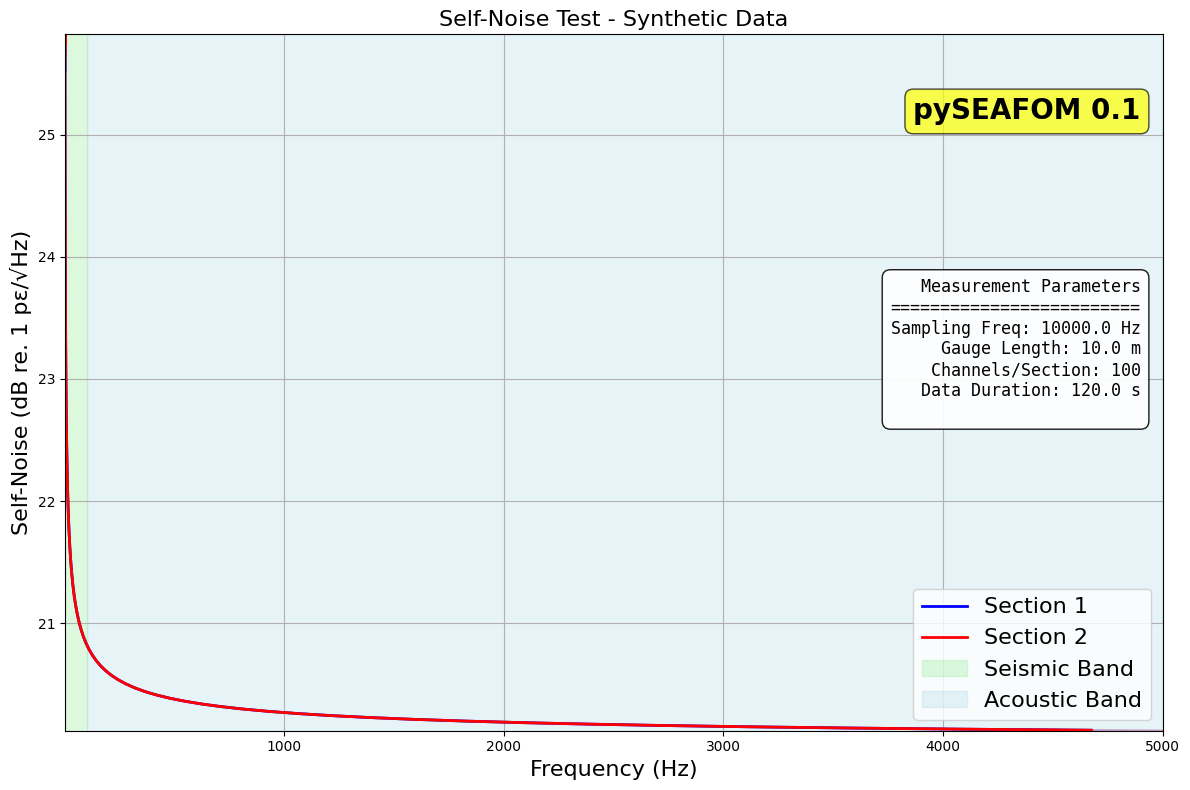

In [ ]:
sections = [data[test_sections_channels[i][0]:test_sections_channels[i][1]+1, :] for i in range(len(test_sections))]
results = self_noise.calculate_self_noise(sections, interrogation_rate=fs, window_function='none', data_type=data_unit)

self_noise.plot_combined_self_noise_db(
    results=results,
    title='Self-Noise Test - Synthetic Data',
    test_sections=test_sections,
    gauge_length=gauge_length,
    data_unit=data_unit,
    sampling_freq=fs,
    n_channels=40,
    duration=duration
)
plt.show()

## 6. Text-Based Reporting with `report_self_noise()`

Demonstrate the text-based reporting function that prints self-noise values at key frequencies and optional frequency bands.

**Features**:
- Reports self-noise values at standard frequencies (10, 100, 1000, 10000 Hz)
- Optional frequency band analysis (e.g., seismic 1-100 Hz, acoustic 100-1000 Hz)
- Supports both linear units and dB scale
- Useful for generating text-based test reports and documentation

In [ ]:
# Generate text-based report
sections = [data[test_sections_channels[i][0]:test_sections_channels[i][1]+1, :] for i in range(len(test_sections))]
results = self_noise.calculate_self_noise(sections, interrogation_rate=fs, window_function='none', data_type=data_unit)

self_noise.report_self_noise(
    results=results,
    gauge_length=gauge_length,
    test_sections=test_sections,
    band_frequencies=[(1, 100), (100, 1000), (1000, 5000)], 
    report_in_db=False,
    data_unit=data_unit
)


Processing section 1/2
Processing section 2/2

pySEAFOM 0.1 - Self-Noise Test Report (Gauge Length: 10.0 m)
----------------------------------------------------------

Section 1:
  Number of frequency points: 600000
  Self-noise values (pε per root Hz) at key frequencies:
    Frequency (Hz) | Self-Noise (pε/rtHz)
    --------------- | --------------------------
    10.00          | 1.30e+01                 
    100.00         | 1.10e+01                 
    1000.00        | 1.03e+01                 
    4999.99        | 1.01e+01                 

  Average self-noise in specified frequency bands:
    Frequency Band (Hz) | Avg Self-Noise (dB) | Avg Self-Noise (pε/√Hz)
    --------------- | ----------------- | -------------------
    [   1.0,  100.0]   |        21.43 dB |     1.18e+01
    [ 100.0, 1000.0]   |        20.41 dB |     1.05e+01
    [1000.0, 5000.0]   |        20.17 dB |     1.02e+01

Section 2:
  Number of frequency points: 600000
  Self-noise values (pε per root Hz) at key f